In [1]:
import bz2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import gzip
from heapq import heappushpop
from joblib import Parallel, delayed
import time

In [2]:
import numpy as np
import os

classes = []

for root, dirs, files in os.walk("."):  
    for filename in files:
        classes.append(filename)

In [3]:
from re import compile

rex = compile('n[0-9]+')
classes = [x for x in classes if rex.match(x)]

In [4]:
x_trn = []
y_trn = []
for c in tqdm(classes):
    x_trn.append(np.load(c))
    y_trn += [c] * len(x_trn[-1])

In [5]:
x_trn = np.vstack(x_trn)
print(len(x_trn))
print(len(y_trn))

997659
997659


In [6]:
def get_true_KNN(x_trn,x_tst,K):
    N = x_trn.shape[0]
    N_tst = x_tst.shape[0]
    x_tst_knn_gt = np.zeros((N_tst, N))
    for i_tst in tqdm(range(N_tst)):
        dist_gt = np.zeros(N)
        for i_trn in range(N):
            dist_gt[i_trn] = np.linalg.norm(x_trn[i_trn,:] - x_tst[i_tst, :], 2)
#             if i_trn % 100000 == 0:
#                 print(i_trn)
        x_tst_knn_gt[i_tst, :] = np.argsort(dist_gt)
        # x_sort_part = np.argpartition(dist_gt,K)[:K]
        # x_tst_knn_gt[i_tst, :] = x_sort_part[np.argsort(dist_gt[x_sort_part])]
#         if i_tst % 100 == 0:
#             print(i_tst)

    return x_tst_knn_gt.astype(int)

In [7]:
from sklearn.utils import shuffle
x_trn, y_trn = shuffle(x_trn, y_trn, random_state=0)

In [8]:
x_trn = np.reshape(x_trn, (-1, 2048))
x_tst, y_tst = x_trn[:100], y_trn[:100]
x_val, y_val = x_trn[100:1100], y_trn[100:1100]
x_trn, y_trn = x_trn[1100:], y_trn[1100:]

In [9]:
start = time.time()
x_tst_knn_gt = get_true_KNN(x_trn, x_tst, 1)
end1 = time.time() - start
print(end1)


651.8746099472046


In [10]:
start = time.time()
x_val_knn_gt = get_true_KNN(x_trn, x_val, 1)
val_end1 = time.time() - start
print(val_end1)


6716.966578960419


In [11]:
np.save('eps0.1/tst_exact_knn', x_tst_knn_gt)
np.save('eps0.1/val_exact_knn', x_val_knn_gt)

In [12]:
def compute_single_unweighted_knn_class_shapley(x_trn,y_trn,x_tst_knn_gt,y_tst,K):
    N = x_trn.shape[0]
    N_tst = x_tst_knn_gt.shape[0]
    sp_gt = np.zeros((N_tst,N))
    for j in tqdm(range(N_tst)):
        # try:
        sp_gt[j,x_tst_knn_gt[j,-1]] = (y_trn[x_tst_knn_gt[j,-1]] == y_tst[j])/N
        # except:
        #     pdb.set_trace()
        for i in np.arange(N-2,-1,-1):
            sp_gt[j,x_tst_knn_gt[j,i]] = sp_gt[j,x_tst_knn_gt[j,i+1]] +\
                           (int(y_trn[x_tst_knn_gt[j,i]] == y_tst[j]) -
                            int(y_trn[x_tst_knn_gt[j,i+1]] == y_tst[j]))/K* min([K,i+1])/(i+1)
            # if j == 404 and i == 0:
            #     pdb.set_trace()
    return sp_gt

In [13]:
start = time.time()
sp_gt = compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_tst_knn_gt, y_tst, 1)
end2 = time.time() - start

start = time.time()
val_sp_gt = compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_val_knn_gt, y_val, 1)
val_end2 = time.time() - start

print(end2)
print(val_end2)


483.01669359207153
6093.057049274445


In [14]:
print((end1 + end2) / 100)
print((val_end1 + val_end2) / 1000)

11.348913035392762
12.810023628234863


In [15]:
np.save('tst_exact_sp_gt', sp_gt)
np.save('val_exact_sp_gt', val_sp_gt)

In [16]:
def get_contrast(x_trn):
    num_cores = 8
    mc_num = 5
    eps = 0.1
    n_trn = x_trn.shape[0]
    K = int(1 / eps)
    contrast = np.zeros((mc_num))
    dist_rand = np.zeros(mc_num)
    dist_knn = np.zeros((mc_num))

    def compute_distance(i_q, query,x_trn,n_trn,K):
        dist_to_random = np.zeros(n_trn)
        for i_trn in range(n_trn):
            dist_to_random[i_trn] = np.linalg.norm(query - x_trn[i_trn, :], 2)
        dist_to_random_avg = np.mean(dist_to_random)
        dist_to_KNN = np.sort(dist_to_random)[:K]
        # first_K_ind = np.argpartition(dist_to_random, K)[:K]
        # dist_to_KNN= np.sort(dist_to_random[first_K_ind])
        # print(dist_to_random[dist_to_KNN[i_q, :].astype(int)])
        if i_q % 100 == 0:
            print(i_q)
        return dist_to_random_avg,dist_to_KNN

    def estimate_contrast(x_trn,query,K):
        # estimate empirical contrast
        n_trn = x_trn.shape[0]
        n_q = query.shape[0]
        # dist_to_random_avg = np.zeros(n_q)
        # dist_to_KNN = np.zeros((n_q,K))
        from joblib import Parallel, delayed
        result = \
            Parallel(n_jobs=num_cores)(delayed(compute_distance)(i_q,query[i_q,:],x_trn,n_trn,K) for i_q in range(n_q))
        dist_to_random_avg = np.array([result[i][0] for i in range(n_q)])
        dist_to_KKN = np.array([result[i][1] for i in range(n_q)])
        assert dist_to_KKN.shape[0] == n_q
        dist_to_KNN_avg_q = np.mean(dist_to_KKN,axis=0)
        dist_to_random_avg_avg = np.mean(dist_to_random_avg)
        contrast =dist_to_random_avg_avg/dist_to_KNN_avg_q
        return dist_to_random_avg_avg,dist_to_KNN_avg_q,contrast

    contrast = []
    dist_rand = []
    dist_knn = []
    for mc_i in range(mc_num):
        start = time.time()
        sample_ind_trn = np.random.choice(np.arange(n_trn),int(n_trn/5*4),replace=False).astype(int)
        sample_ind_query = np.array(list(set(np.arange(n_trn).astype(int).tolist()) - set(sample_ind_trn.tolist()))).astype(int)
        # if len(sample_ind_query) + len(sample_ind_trn) != n_trn:
        #     print('dimension does not match')
        dist_rand_, dist_knn_, contrast_ = estimate_contrast(x_trn[sample_ind_trn,:],x_trn[sample_ind_query,:],K)
        dist_rand.append(dist_rand_)
        dist_knn.append(dist_knn_)
        contrast.append(contrast_)

        print('monte carlo iteration%s ' % mc_i)
        elapsed_time = time.time() - start
        print('elapsed time is %s' % elapsed_time)
    dist_knn = np.array(dist_knn)
    contrast = np.array(contrast)
    dist_rand = np.array(dist_rand)
    np.save('eps0.1/dist_rand',dist_rand)
    np.save('eps0.1/dist_knn',dist_knn)
    np.save('eps0.1/contrast',contrast)

In [17]:
K = 10
get_contrast(x_val)
dist_rand = np.load('eps0.1/dist_rand.npy')
contrast = np.load('eps0.1/contrast.npy')
dist_knn = np.load('eps0.1/dist_knn.npy')

dist_rand = np.mean(dist_rand, axis=0)
contrast = np.mean(contrast, axis=0)[K-1]
dist_knn = np.mean(dist_knn, axis=0)[K-1]

monte carlo iteration0 
elapsed time is 4.813538074493408
monte carlo iteration1 
elapsed time is 0.6082043647766113
monte carlo iteration2 
elapsed time is 0.6789493560791016
monte carlo iteration3 
elapsed time is 0.6217498779296875
monte carlo iteration4 
elapsed time is 0.6084952354431152


In [18]:
search_range = np.arange(1e-3, 10, 1e-3)
from scipy.stats import norm


def f_h(x, r):
    y = 1-2*norm.cdf(-r/x) - 2/(np.sqrt(2*np.pi)*r/x)*(1-np.exp(-(r**2/(2*(x**2)))))
    return y

def g_unnormalize(dist_rand,dist_knn,r):
    y = np.log(f_h(dist_knn,r))/np.log(f_h(dist_rand,r))
    return y

def g_normalize(contrast,r):
    y = np.log(f_h(1/contrast,r))/np.log(f_h(1,r))
    return y

def find_best_r_normalize(search_range,contrast):
    y = g_normalize(contrast,search_range)
    min_ind = np.argmin(y)
    return search_range[min_ind]

def find_best_r_unnormalize(search_range,dist_rand,dist_knn):
    y = g_unnormalize(dist_rand,dist_knn,search_range)
    min_ind = np.argmin(y)
    return search_range[min_ind]

r_vec_normalize = find_best_r_normalize(search_range, contrast)
g_vec = g_normalize(contrast, r_vec_normalize)

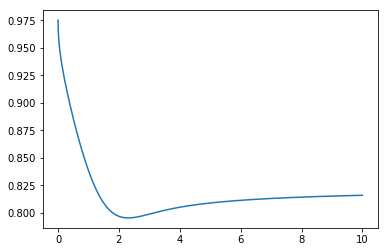

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot g(C_K) vs r, we want g(C_k) to be small
g = g_normalize(contrast,search_range)
plt.figure()
plt.plot(search_range,g)
plt.show()


In [21]:
# search range, find r that minimize g, shape should be 类似 convex

# np.save('data/mnist_mini_selected_param_r_' + str(K) + '.npy', r_vec_normalize)
# np.save('data/mnist_mini_selected_param_g_' + str(K) + '.npy', g_vec)
np.save('eps0.1/selected_param_r_' + str(K) + '.npy', r_vec_normalize)
np.save('eps0.1/selected_param_g_' + str(K) + '.npy', g_vec)

In [22]:
t = r_vec_normalize
n_trn = len(x_trn)
n_hash_table = 10 # 如果 estimation error 高于 0.01
n_hash_bit = int(np.ceil(np.log(n_trn)*0.5/ np.log(1 / f_h(1, t))))
print(n_hash_bit)

17


In [29]:
import numpy as np
import pdb


def lsh_function(t,x,w,b):
    # x is 1-d array
    h = np.floor((np.dot(w,x)+b)/t).astype(int)
    return h


class LSH:
    def __init__(self,n_hash_bit,n_hash_table,x_trn,y_trn,t=0.1):
        self.n_hash_bit = n_hash_bit
        self.n_hash_table = n_hash_table
        self.t = t # width of projections
        self.x_trn = x_trn
        self.y_trn = y_trn
        self.N, self.dim = x_trn.shape
        # draw w from a normal distribution (2-stable)
        self.w = np.random.normal(0, 1, (n_hash_table, n_hash_bit, self.dim))
        # draw b from U[0,t]
        self.b = np.random.uniform(0, self.t, (n_hash_table, n_hash_bit))
        self.x_trn_hash = [dict() for i in range(n_hash_table)]
        for i in tqdm(range(self.N)):
            hash_code_all = lsh_function(self.t, x_trn[i] / dist_rand, self.w, self.b)
            for l in range(n_hash_table):
                hash_code_trn = '.'.join(map(str, hash_code_all[l, :]))
                if hash_code_trn in self.x_trn_hash[l].keys():
                    self.x_trn_hash[l][hash_code_trn].append(i)
                else:
                    self.x_trn_hash[l][hash_code_trn] = [i]
#             if i % 1000 == 0:
#                 print('build hash %s'%i)

    def get_approx_KNN(self,x_tst,K):
        N_tst = x_tst.shape[0]
        x_tst_knn = np.ones((N_tst, K)) * (-1)
        nns_len = np.zeros(N_tst)
        for i_tst in tqdm(range(N_tst)):
            nns = []
            for l in range(self.n_hash_table):
                hash_code_int = lsh_function(self.t, x_tst[i_tst] / dist_rand, self.w[l, :, :], self.b[l, :])
                hash_code_test = '.'.join(map(str, hash_code_int))
                if hash_code_test in self.x_trn_hash[l].keys():
                    nns += self.x_trn_hash[l][hash_code_test]
            nns = np.unique(nns)
            num_collide_elements = len(nns)
            if len(nns) > 0:
                dist = [np.linalg.norm(self.x_trn[i] / dist_rand - x_tst[i_tst] / dist_rand, 2) for i in nns]
                dist_min_ind = nns[np.argsort(dist)]
                if num_collide_elements < K:
                    x_tst_knn[i_tst, :num_collide_elements] = dist_min_ind[:num_collide_elements]
                else:
                    x_tst_knn[i_tst, :] = dist_min_ind[:K]
            # pdb.set_trace()
            nns_len[i_tst] = len(nns)
            if i_tst % 100 == 0:
                print('get approximate knn %s'%i_tst)
        return x_tst_knn.astype(int),nns_len


    def compute_approx_shapley(self,x_tst_knn,y_tst,K):
        N_tst,K_star = x_tst_knn.shape
        # flag_sufficient = (x_tst_knn[:,-1]>=0)
        sp_approx = np.zeros((N_tst,self.N))
        for j in tqdm(range(N_tst)):
            non_nan_index = np.where(x_tst_knn[j,:]>=0)[0]
            if len(non_nan_index)== 0:
                continue
            K_tot = non_nan_index[-1]
            if K_tot == self.N:
                sp_approx[j, x_tst_knn[j, self.N - 1]] = equal(self.y_trn[x_tst_knn[j, self.N - 1]], y_tst[j]) / self.N
            for i in np.arange(K_tot - 1, -1, -1):
                sp_approx[j, x_tst_knn[j, i]] = sp_approx[j, x_tst_knn[j, i+1]] + (
                        equal(self.y_trn[x_tst_knn[j, i]], y_tst[j]) - equal(
                    self.y_trn[x_tst_knn[j, i + 1]], y_tst[j])) / K * min([K, i + 1]) / (i + 1)



        return sp_approx

In [36]:
def equal(a, b):
    return a == b
    
def fine_tune(n_hash_table=10, alpha=0.5, file=False):
    t = r_vec_normalize
    n_trn = len(x_trn)
    n_hash_bit = int(np.ceil(np.log(n_trn)*alpha/ np.log(1 / f_h(1, t))))
    if file is True:
        print(n_hash_bit, file=open('eps0.1/log.txt', 'a'))
    else:
        print(n_hash_bit)
    
    start = time.time()
    lsh = LSH(n_hash_bit=n_hash_bit, n_hash_table=n_hash_table, x_trn=x_trn, y_trn=y_trn, t=t)
    runtime_build_hash = time.time() - start
    if file is True:
        print(runtime_build_hash, file=open('eps0.1/log.txt', 'a'))
    else:
        print(runtime_build_hash)
    
    K_star = 10
    start = time.time()
    x_val_knn_approx, nns_vec = lsh.get_approx_KNN(x_val, K_star)
    runtime_query = time.time() - start
    if file is True:
        print(runtime_query, file=open('eps0.1/log.txt', 'a'))
    else:
        print(runtime_query)
    
    K = 1
    start = time.time()
    sp_approx = lsh.compute_approx_shapley(x_val_knn_approx, y_val, K)
    runtime_approx_value = time.time() - start
    if file is True:
        print('it takes %s to get appox knn value' % runtime_approx_value, file=open('eps0.1/log.txt', 'a'))
    else:
        print('it takes %s to get appox knn value' % runtime_approx_value)
    
    sp_err_inf_val= np.linalg.norm(val_sp_gt - sp_approx,ord=np.inf, axis=1)
    if file is True:
        print('max error %s'% np.percentile(sp_err_inf_val,90), file=open('eps0.1/log.txt', 'a'))
    else:
        print('max error %s'% np.percentile(sp_err_inf_val,90))
    return lsh

In [37]:
def fine_tune_test(n_hash_table=10, lsh=None, file=False):
    if not lsh:
        t = r_vec_normalize
        n_trn = len(x_trn)
        n_hash_bit = int(np.ceil(np.log(n_trn)*0.3/ np.log(1 / f_h(1, t))))
        print(n_hash_bit)
    
        start = time.time()
        lsh = LSH(n_hash_bit=n_hash_bit, n_hash_table=n_hash_table, x_trn=x_trn_norm, y_trn=y_trn, t=t)
        runtime_build_hash = time.time() - start
        print(runtime_build_hash)
    
    K_star = 10
    start = time.time()
    x_tst_knn_approx, nns_vec = lsh.get_approx_KNN(x_tst, K_star)
    runtime_query = time.time() - start
    if file is True:
        print(runtime_query, file=open('eps0.1/log.txt', 'a'))
    else:
        print(runtime_query)
    
    K = 1
    start = time.time()
    sp_approx = lsh.compute_approx_shapley(x_tst_knn_approx, y_tst, K)
    runtime_approx_value = time.time() - start
    if file is True:
        print('it takes %s to get appox knn value' % runtime_approx_value, file=open('eps0.1/log.txt', 'a'))
    else:
        print('it takes %s to get appox knn value' % runtime_approx_value)
    
    sp_err_inf_val= np.linalg.norm(sp_gt - sp_approx,ord=np.inf, axis=1)
    if file is True:
        print('max error %s'% np.percentile(sp_err_inf_val,90), file=open('eps0.1/log.txt', 'a'))
    else:
        print('max error %s'% np.percentile(sp_err_inf_val,90))
    return sp_approx, nns_vec

In [38]:
lsh_10_038 = fine_tune(10, 0.38, file=True)
sp_approx_10_038, nns_vec_10_038 = fine_tune_test(10, lsh_10_038, file=True)

get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900



get approximate knn 0



In [ ]:
lsh_50_038 = fine_tune(50, 0.38, file=True)
sp_approx_50_038, nns_vec_50_038 = fine_tune_test(50, lsh_50_038, file=True)

get approximate knn 0


In [ ]:
lsh_80_038 = fine_tune(80, 0.38, file=True)
sp_approx_80_038, nns_vec_80_038 = fine_tune_test(80, lsh_80_038, file=True)

In [ ]:
lsh_80_04 = fine_tune(80, 0.4, file=True)
sp_approx_80_04, nns_vec_80_04 = fine_tune_test(80, lsh_80_04, file=True)

In [ ]:
lsh_150_05 = fine_tune(150, 0.5, file=True)
sp_approx_150_05, nns_vec_150_05 = fine_tune_test(150, lsh_150_05, file=True)

In [43]:
contrast

1.2163584319205043

In [44]:
lsh_200_05 = fine_tune(200, 0.5, file=True)
sp_approx_200_05, nns_vec_200_05 = fine_tune_test(200, lsh_200_05, file=True)

get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900



get approximate knn 0



In [ ]:
lsh_90_04 = fine_tune(90, 0.4, file=True)
sp_approx_90_04, nns_vec_90_04 = fine_tune_test(90, lsh_90_04, file=True)

get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300


In [ ]:
lsh_60_038 = fine_tune(60, 0.38, file=True)
sp_approx_60_038, nns_vec_60_038 = fine_tune_test(60, lsh_60_038, file=True)

In [47]:
lsh_95_04 = fine_tune(95, 0.4, file=True)
sp_approx_95_04, nns_vec_95_04 = fine_tune_test(95, lsh_95_04, file=True)

get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900



get approximate knn 0



In [48]:
lsh_65_038 = fine_tune(65, 0.38, file=True)
sp_approx_65_038, nns_vec_65_038 = fine_tune_test(65, lsh_65_038, file=True)

get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900



get approximate knn 0



In [ ]:
lsh_190_05 = fine_tune(190, 0.5, file=True)
sp_approx_190_05, nns_vec_190_05 = fine_tune_test(190, lsh_190_05, file=True)

In [51]:
lsh_300_053 = fine_tune(300, 0.53, file=True)
sp_approx_300_053, nns_vec_300_053 = fine_tune_test(300, lsh_300_053, file=True)

get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900


get approximate knn 0


In [ ]:
lsh_200_053 = fine_tune(200, 0.53, file=True)
sp_approx_200_053, nns_vec_200_053 = fine_tune_test(200, lsh_200_053, file=True)

In [ ]:
lsh_195_05 = fine_tune(195, 0.5, file=True)
sp_approx_195_05, nns_vec_195_05 = fine_tune_test(195, lsh_195_05, file=True)

In [ ]:
lsh_230_053 = fine_tune(230, 0.53, file=True)
sp_approx_230_053, nns_vec_230_053 = fine_tune_test(230, lsh_230_053, file=True)

In [56]:
lsh_250_053 = fine_tune(250, 0.53, file=True)
sp_approx_250_053, nns_vec_250_053 = fine_tune_test(250, lsh_230_053, file=True)

get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900


get approximate knn 0


In [57]:
sp_approx_250_053, nns_vec_250_053 = fine_tune_test(250, lsh_250_053, file=True)

get approximate knn 0


In [ ]:
lsh_255_053 = fine_tune(255, 0.53, file=True)
sp_approx_255_053, nns_vec_255_053 = fine_tune_test(255, lsh_255_053, file=True)